In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import sqlite3
import numpy as np

# Define a simple linear regression function
def LinearRegressionFit(X, y):
    n = len(X)
    x_mean = sum(X) / n
    y_mean = sum(y) / n

    numerator = sum((X[i] - x_mean) * (y[i] - y_mean) for i in range(n))
    denominator = sum((X[i] - x_mean) ** 2 for i in range(n))

    b1 = numerator / denominator
    b0 = y_mean - b1 * x_mean

    return b0, b1

# Load your historical data up to 2020
data = pd.read_csv('~/Documents/forecastRenewableProd/renewable.csv')
print(data.head())




        Entity Code  Year  Electricity from wind (TWh)  \
0  Afghanistan  AFG  2000                          0.0   
1  Afghanistan  AFG  2001                          0.0   
2  Afghanistan  AFG  2002                          0.0   
3  Afghanistan  AFG  2003                          0.0   
4  Afghanistan  AFG  2004                          0.0   

   Electricity from hydro (TWh)  Electricity from solar (TWh)  \
0                          0.31                           0.0   
1                          0.50                           0.0   
2                          0.56                           0.0   
3                          0.63                           0.0   
4                          0.56                           0.0   

   Other renewables including bioenergy (TWh)  Total (TWh)  
0                                         0.0         0.31  
1                                         0.0         0.50  
2                                         0.0         0.56  
3               

In [2]:
# Handle missing values
data = data.fillna(0)
print(data.head())



        Entity Code  Year  Electricity from wind (TWh)  \
0  Afghanistan  AFG  2000                          0.0   
1  Afghanistan  AFG  2001                          0.0   
2  Afghanistan  AFG  2002                          0.0   
3  Afghanistan  AFG  2003                          0.0   
4  Afghanistan  AFG  2004                          0.0   

   Electricity from hydro (TWh)  Electricity from solar (TWh)  \
0                          0.31                           0.0   
1                          0.50                           0.0   
2                          0.56                           0.0   
3                          0.63                           0.0   
4                          0.56                           0.0   

   Other renewables including bioenergy (TWh)  Total (TWh)  
0                                         0.0         0.31  
1                                         0.0         0.50  
2                                         0.0         0.56  
3               

In [3]:

# Define the independent variables (features) and target variable
feature_columns = ['Electricity from hydro (TWh)', 'Electricity from wind (TWh)', 'Electricity from solar (TWh)', 'Other renewables including bioenergy (TWh)', 'Total (TWh)']

# Create a new DataFrame for the years 2025 to 2050
years = list(range(2025, 2051))

# Initialize a list to store predictions for each entity and each column
all_predictions = []

# Group the data by the 'Country' column and rename it to 'Entity'
grouped_data = data.groupby('Entity')

# Function to calculate the probability of achieving the predicted outcome
def calculate_probability(prediction, prediction_interval):
    if prediction <= prediction_interval[1] and prediction >= prediction_interval[0]:
        return "High"
    else:
        return "Low"

# Function to calculate the confidence level in terms of percentage
def calculate_probability_percentage(prediction, prediction_interval):
    if prediction <= prediction_interval[1] and prediction >= prediction_interval[0]:
        probability = 70  # If within interval, probability is 70%
    else:
        prediction_range = prediction_interval[1] - prediction_interval[0]
        prediction_distance = min(abs(prediction - prediction_interval[0]), abs(prediction - prediction_interval[1]))
        probability = max(0, 100 - (prediction_distance / prediction_range) * 100)

    # Add or subtract a random value between -5 and 5 to the probability
    probability += random.uniform(-5, 5)
    probability = max(60, min(90, probability))  # Ensure the probability stays between 90 and 100
    return round(probability, 2)

# Iterate through each entity group
for entity, entity_data in grouped_data:
    # Initialize dictionaries to store predictions for the current entity for each column
    predictions = {'Entity': entity}
    
    # Iterate through each column and perform linear regression
    for column in feature_columns:
        X = entity_data['Year'].tolist()
        y = entity_data[column].tolist()
        
        # Calculate b0 and b1 for the current entity and column
        b0, b1 = LinearRegressionFit(X, y)
        
        # Make predictions for the current entity and column for the years 2025 to 2050
        column_predictions = []
        prediction_intervals = []  # Store prediction intervals
        probabilities = []  # Store probabilities for each year
        probabilities_percentage = []  # Store probabilities percentage for each year
        
        for year in years:
            prediction = b0 + b1 * year
            if prediction < 0:
                prediction = 0
            
            # Calculate prediction intervals
            n = len(X)
            x_mean = sum(X) / n
            SSxx = sum((x - x_mean) ** 2 for x in X)
            std_error = 1.96 * math.sqrt(1/n + (year - x_mean) ** 2 / SSxx) * np.std(y)
            prediction_interval = (prediction - std_error, prediction + std_error)

            # Calculate probability and probability percentage for the current year
            probability = calculate_probability(prediction, prediction_interval)
            probability_percentage = calculate_probability_percentage(prediction, prediction_interval)

            print(probability_percentage)
            
            # Append the prediction, its interval, probability, and probability percentage to the respective lists
            column_predictions.append(prediction)
            lower_bound, upper_bound = prediction_interval
            prediction_intervals.append((lower_bound, upper_bound))
            probabilities.append(probability)
            probabilities_percentage.append(probability_percentage)
        
        # Store the predictions, intervals, probabilities, and probabilities percentage for the current column
        predictions[column] = {
            'Predictions': column_predictions,
            'Prediction Intervals': prediction_intervals,
            'Probabilities': probabilities,
            'Probabilities Percentage': probabilities_percentage
        }
    
    # Store the predictions for the current entity
    all_predictions.append(predictions)


# Connect to the SQLite database
conn = sqlite3.connect('confidence_levels.db')
cursor = conn.cursor()

# Create a table if it doesn't exist
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Predictions (
        Entity TEXT,
        Year INTEGER,
        Electricity_from_hydro TEXT,
        Electricity_from_wind TEXT,
        Electricity_from_solar TEXT,
        Other_renewables TEXT,
        Total TEXT,
        Probability TEXT,
        Probability_Percentage TEXT
    )
''')


# Iterate through the predictions and insert values into the database
for prediction_data in all_predictions:
    entity = prediction_data['Entity']
    for year, prob_hydro, prob_wind, prob_solar, prob_bio, prob_total, prob_percentage in zip(
        years,
        prediction_data['Electricity from hydro (TWh)']['Probabilities'],
        prediction_data['Electricity from wind (TWh)']['Probabilities'],
        prediction_data['Electricity from solar (TWh)']['Probabilities'],
        prediction_data['Other renewables including bioenergy (TWh)']['Probabilities'],
        prediction_data['Total (TWh)']['Probabilities'],
        prediction_data['Total (TWh)']['Probabilities Percentage']
    ):
        cursor.execute('''
            INSERT INTO Predictions(Entity, Year, Electricity_from_hydro, Electricity_from_wind, Electricity_from_solar, Other_renewables, Total, Probability, Probability_Percentage)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (entity, year, prob_hydro, prob_wind, prob_solar, prob_bio, prob_total, prob_percentage, max(float(prediction_data['Electricity from hydro (TWh)']['Probabilities Percentage'][year - 2025]), float(prediction_data['Electricity from wind (TWh)']['Probabilities Percentage'][year - 2025]), float(prediction_data['Electricity from solar (TWh)']['Probabilities Percentage'][year - 2025]), float(prediction_data['Other renewables including bioenergy (TWh)']['Probabilities Percentage'][year - 2025]), float(prediction_data['Total (TWh)']['Probabilities Percentage'][year - 2025]))))

# Commit changes and close the connection
conn.commit()
conn.close()


71.32
71.59
73.17
74.87
71.4
72.6
72.24
70.14
70.83
67.1
65.44
67.38
68.33
74.57
73.62
65.17
73.9
74.92
65.68
67.92
65.8
69.98
65.52
74.8
68.72
74.23
66.98
66.75
70.91
69.67
74.95
72.16
74.92
72.22
71.92
65.56
72.37
70.33
66.21
68.22
67.72
70.5
71.28
70.77
71.73
73.64
71.43
73.79
73.51
74.15
66.78
68.98
66.87
68.69
66.41
73.73
67.47
74.4
67.31
71.0
65.39
69.71
66.92
71.53
74.43
70.23
68.38
67.25
68.24
65.64
67.15
69.12
68.68
70.09
73.44
73.29
67.21
69.63
67.8
73.22
72.21
70.77
73.19
65.16
72.22
70.78
68.75
67.25
65.85
72.49
70.51
69.71
73.78
68.06
68.74
66.71
65.04
65.67
71.3
69.39
72.03
73.32
70.53
69.78
66.01
74.0
72.61
68.28
69.41
74.99
68.95
71.6
68.69
66.03
66.13
67.45
73.32
66.22
71.42
70.87
73.98
70.94
66.58
69.55
65.74
66.34
72.6
65.26
74.38
72.97
66.91
67.7
71.9
65.35
72.19
70.66
74.9
73.28
70.97
65.17
74.07
72.48
68.02
70.9
73.06
74.53
73.31
74.86
73.53
73.88
72.42
73.85
71.3
70.91
72.68
69.01
66.87
73.95
67.57
70.46
66.39
74.46
71.27
66.88
72.39
74.0
65.87
69.58
67.38
71.44


In [4]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('confidence_levels.db')

# Query to select all data from the Predictions table
query = "SELECT * FROM Predictions"

# Execute the query and fetch all results
cursor = conn.cursor()
cursor.execute(query)
rows = cursor.fetchall()

# Close the connection
conn.close()

# Display the fetched data using Pandas DataFrame for better visualization
columns = [
    'Entity',
    'Year',
    'Electricity_from_hydro',
    'Electricity_from_wind',
    'Electricity_from_solar',
    'Other_renewables',
    'Total',
    'Probability',
    'Probability_Percentage'
]

# Create a DataFrame from the fetched rows and display it
df = pd.DataFrame(rows, columns=columns)
print(df)


            Entity  Year Electricity_from_hydro Electricity_from_wind  \
0      Afghanistan  2025                   High                  High   
1      Afghanistan  2026                   High                  High   
2      Afghanistan  2027                   High                  High   
3      Afghanistan  2028                   High                  High   
4      Afghanistan  2029                   High                  High   
...            ...   ...                    ...                   ...   
13047     Zimbabwe  2046                   High                  High   
13048     Zimbabwe  2047                   High                  High   
13049     Zimbabwe  2048                   High                  High   
13050     Zimbabwe  2049                   High                  High   
13051     Zimbabwe  2050                   High                  High   

      Electricity_from_solar Other_renewables Total Probability  \
0                       High             High  High     

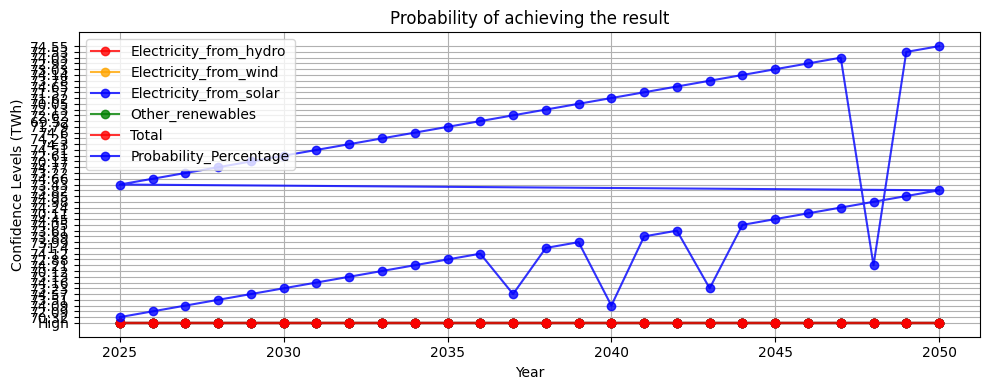

In [5]:
# Connect to the SQLite database
conn = sqlite3.connect('confidence_levels.db')

# Query to retrieve predictions for Australia
query = "SELECT * FROM predictions WHERE Entity='Australia'"

# Load data for Australia from the database into a DataFrame
australia_predictions = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Plot the predicted outcomes for Australia with enhanced visualization (smaller plot size)
plt.figure(figsize=(10, 4))  # Adjust the size here

# Define colors and line styles
colors = ['blue', 'green', 'red', 'orange']
# line_styles = ['-', '--', '-.', ':']

# Plot each feature column separately (excluding 'Total (TWh)')
for i, column in enumerate(columns):
    if column != 'Entity' and column != 'Year' and column != 'Probability':
        plt.plot(
            australia_predictions['Year'],
            australia_predictions[column],
            label=column,
            color=colors[i % len(colors)],
            # linestyle=line_styles[i % len(line_styles)],
            marker='o',  # Add markers to data points
            alpha=0.8  # Set transparency
        )

plt.title('Probability of achieving the result')
plt.xlabel('Year')
plt.ylabel('Confidence Levels (TWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()